In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load simulation results from JSON file
with open('3d_simulation_results.json', 'r') as json_file:
    quantum_simulation_data = json.load(json_file)

quantum_simulation_results = []
for data_point in quantum_simulation_data:
    theta_val = data_point['theta']
    phi_val = data_point['phi']
    zeta_val = data_point['zeta']
    result = data_point['result']
    total_counts = sum(result.values())
    error_counts = total_counts - result.get('000', 0)  # Assuming '000' is the expected outcome
    error_rate = error_counts / total_counts
    quantum_simulation_results.append((theta_val, phi_val, zeta_val, error_rate))


# Convert to DataFrame
df = pd.DataFrame(quantum_simulation_results, columns=['theta', 'phi', 'zeta', 'error_rate'])


# Prepare your data
X = df[['theta', 'phi', 'zeta']].values  # Features
y = df['error_rate'].values              # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Activation functions to try
activation_functions = ['relu', 'tanh', 'sigmoid', 'elu', 'selu', 'swish']

# Optimizers to try
optimizers_to_try = [
    optimizers.Adagrad(),
    optimizers.Adamax(),
    optimizers.Nadam(),
]

# Results dictionary for neural network training
nn_training_results = {}

for activation in activation_functions:
    for opt in optimizers_to_try:
        # Build the model with the chosen activation function
        model = models.Sequential([
            layers.Dense(128, activation=activation, input_shape=(3,)),
            layers.Dense(128, activation=activation),
            layers.Dense(64, activation=activation),
            layers.Dense(64, activation=activation),
            layers.Dense(32, activation=activation),
            layers.Dense(1)  # Output layer: no activation, we want a regression output
        ])

        # Compile the model with the chosen optimizer
        model.compile(optimizer=opt, loss='mean_squared_error')

        # Train the model
        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, verbose=0)

        # Evaluate the model
        loss = model.evaluate(X_test, y_test, verbose=0)
        
        # Save the results
        nn_training_results[(activation, opt.get_config()['name'])] = loss
        print(f"Activation: {activation}, Optimizer: {opt.get_config()['name']}, Test loss: {loss}")

Activation: relu, Optimizer: Adagrad, Test loss: 0.011220315471291542
Activation: relu, Optimizer: Adamax, Test loss: 0.0007172038313001394
Activation: relu, Optimizer: Nadam, Test loss: 0.0003428952768445015


KeyError: in user code:

    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1130, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/Users/hoangnguyen/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense_18/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adagrad.'


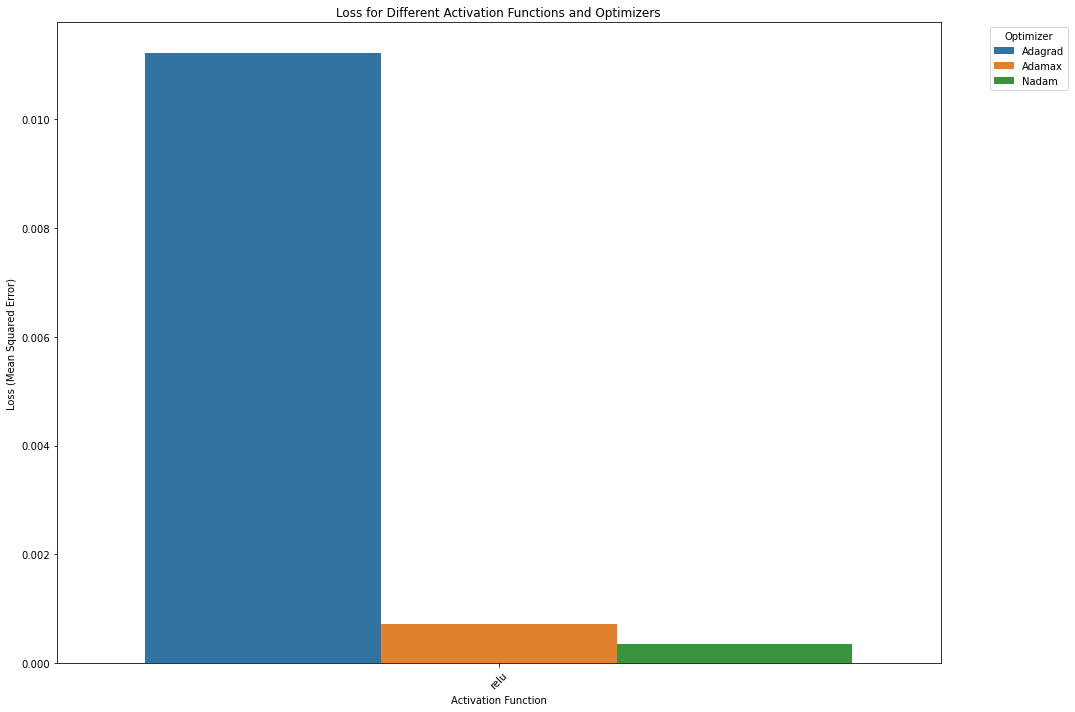

In [13]:
# Convert the results dictionary to a DataFrame for easier plotting
results_df = pd.DataFrame(list( nn_training_results.items()), columns=['Combination', 'Loss'])
results_df[['Activation', 'Optimizer']] = pd.DataFrame(results_df['Combination'].tolist(), index=results_df.index)
results_df.drop(columns='Combination', inplace=True)

# Plotting
plt.figure(figsize=(15, 10))
sns.barplot(data=results_df, x='Activation', y='Loss', hue='Optimizer')
plt.title('Loss for Different Activation Functions and Optimizers')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Activation Function')
plt.xticks(rotation=45)
plt.legend(title='Optimizer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
